**Import dependencies**

In [115]:
#!pip install scikit-fuzzy
!pip install simpful

In [304]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import segment
import fit
from scipy.stats import linregress, iqr
import numpy as np
import skfuzzy as fuzz # requires pip install
import simpful as sf # requires pip install
import matplotlib.pyplot as plt
import operator
import statistics

In [245]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

with open("example_data/16265-normalecg.txt") as f:
    file_lines = f.readlines()

data = [float(x.split("\t")[2].strip()) for x in file_lines[100:520]]

max_error = 0.005

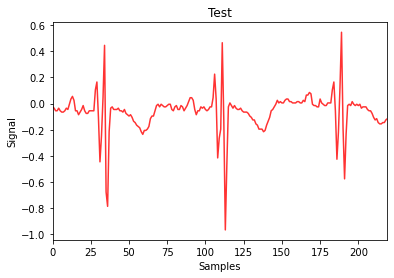

In [14]:
figure()
draw_plot(data, plot_title = 'Test')

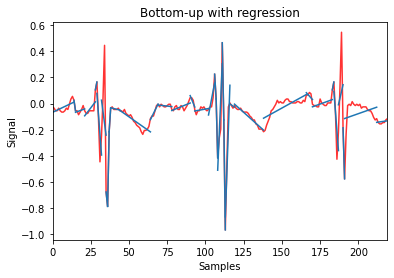

In [7]:
figure()
segments = segment.bottomupsegment(data, fit.regression, fit.sumsquared_error, max_error)
draw_plot(data,"Bottom-up with regression")
draw_segments(segments)

<Figure size 432x288 with 0 Axes>

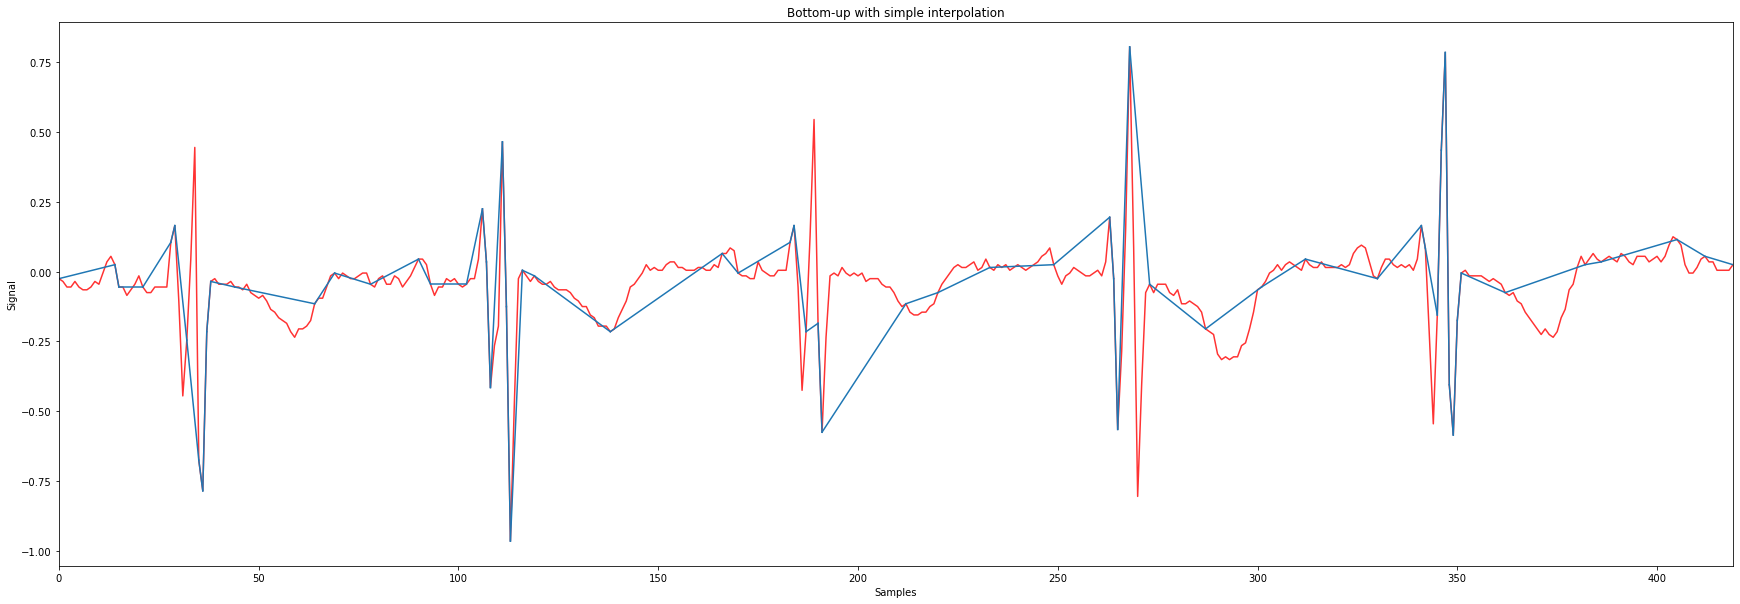

In [246]:
#bottom-up with  simple interpolation
figure()
plt.figure(figsize=(30,10))
segments = segment.bottomupsegment(data, fit.interpolate, fit.sumsquared_error, max_error)
draw_plot(data,"Bottom-up with simple interpolation")
draw_segments(segments)

In [247]:
len(segments)

61

**Calculate Segments**

In [84]:
def slope(series):
    slope_series = []
    for segment in series:
        start, start_val, end, end_val = segment
        slope = (end_val-start_val)/(end-start)
        slope_series.append(slope)
    return slope_series

**Trend Analysis**

In [345]:
# calculate segment specific slope
# output values are between -1 and 1

def dynamics(series):
    '''
    1. Input segment series.
    2. Return angle of slope.
    '''
    slope_series = []
    for segment in series:
        x0, y0, x1, y1 = segment
        angle = round((np.rad2deg(np.arctan2(y1 - y0, x1 - x0))), 2)
        slope_series.append(angle)
        
    return slope_series

def duration(series):
    '''
    1. Input segment series.
    2. Return segment-specific duration.
    '''
    duration_series = []
    for segment in series:
        start, _, end, _ = segment
        length = end-start
        duration_series.append(length)
    return duration_series


# calculate variability
def variability(data, segments):
    '''
    1. Input value range as array.
    2. Return interquartile range.
    '''
    variability_series = []
    for segment in segments:
        start, _, end, _ = segment
        x = np.array(data[start:end+1])
        segment_iqr = round(iqr(x), 4)
        variability_series.append(segment_iqr)
    return variability_series

# calculate variability
#def variability(value_range):
#    '''
#    1. Input value range as array.
#    2. Return interquartile range.
#    '''
#    x = np.array(value_range)
#    iqr = round(iqr(x), 4)
#    return iqr

**Fuzzy logic**

In [253]:
def standardisation(series):
    mean = round(statistics.mean(series), 2)
    sd = round(statistics.stdev(series), 2)
    
    standardisation_series = []
    for segment_value in series:
        val = round(((segment_value - mean) / sd), 2)
        standardisation_series.append(val)
    return standardisation_series

def categorise_slope(series):
    '''
    1. Input segment-specific slopes.
    2. Return dict of slope categories.
    '''
    dynamic_of_change = {
    'quickly increasing' : 0,
    'increasing' : 0,
    'slowly increasing' : 0,
    'constant' : 0,
    'slowly decreasing' : 0,
    'decreasing' : 0,
    'quickly decreasing' : 0}
    for segment in series:
        if segment <= np.quantile(series, 1/7):
            dynamic_of_change['quickly decreasing'] += 1
        if segment > np.quantile(series, 1/7) and segment <= np.quantile(series, 2/7):
            dynamic_of_change['decreasing'] += 1
        if segment > np.quantile(series, 2/7) and segment <= np.quantile(series, 3/7):
            dynamic_of_change['slowly decreasing'] += 1
        if segment > np.quantile(series, 3/7) and segment <= np.quantile(series, 4/7):
            dynamic_of_change['constant'] += 1
        if segment > np.quantile(series, 4/7) and segment <= np.quantile(series, 5/7):
            dynamic_of_change['slowly increasing'] += 1
        if segment > np.quantile(series, 5/7) and segment <= np.quantile(series, 6/7):
            dynamic_of_change['increasing'] += 1
        if segment > np.quantile(series, 6/7):
            dynamic_of_change['quickly increasing'] += 1
    
    return dynamic_of_change

def categorise_variability(series):
    '''
    1. Input segment-specific variabilities.
    2. Return dict of variability categories.
    '''

    dict_variability = {
    'very high' : 0,
    'high' : 0,
    'medium' : 0,
    'low' : 0,
    'very low' : 0
    }
    
    for segment in series:
        if segment <= 1/5:
            dict_variability['very low'] += 1
        if segment > 1/5 and segment <= 2/5:
            dict_variability['low'] += 1
        if segment > 2/5 and segment <= 3/5:
            dict_variability['medium'] += 1
        if segment > 3/5 and segment <= 4/5:
            dict_variability['high'] += 1
        if segment > 4/5:
            dict_variability['very high'] += 1

    
    return dict_variability

#def categorise_duration(series):
#    '''
#    1. Input segment-specific durations.
#    2. Normalise input via standard normalisation.
#    3. Return dict of duration categories.
#    '''
#    dynamic_of_change = {
#    'quickly increasing' : 0,
#    'increasing' : 0,
#    'slowly increasing' : 0,
#    'constant' : 0,
#    'slowly decreasing' : 0,
#    'decreasing' : 0,
#    'quickly decreasing' : 0}
#    for segment in series:
#        if segment < 0 and segment > -0.25:
#            dynamic_of_change['slowly decreasing'] += 1
#        if segment < -0.25 and segment > -0.5:
#            dynamic_of_change['decreasing'] += 1
#        # ...
#    
#    return dynamic_of_change

#def describe_slope(slope_dict):
#    '''
#    1. Input dict of slope categories.
#    2. Return sentence.
#    '''
#    predicate = 'most trends are '
#    var = str(max(slope_dict, key = dynamic_of_change.get))
#    eos = '.'
#    
#    return predicate + var + eos


In [254]:
categorise_variability(a)

{'very high': 0, 'high': 1, 'medium': 5, 'low': 11, 'very low': 44}

In [366]:
def quantity_in_agreement(data, series, func, eval_func):
    
    '''
    1. Input dict of categorisation of trend analysis components.
    2. Calculate distribution of categories.
    3. Return most often occurring distribution category in linguistic form.
    '''
    # key, dict = max_slope(series)
    # TODO better variable naming
    
    a = func(data, series)
    key, dict_categorised = eval_func(a)
    
    total = 0

    for value in dict_categorised.values():
        total += len(value)

    candidate = max(dict_categorised, key = lambda x: len(dict_categorised.get(x)))
    #print(candidate)

    quantifier = {
    'Almost all of ' : 0,
    'Most of' : 0,
    'At least a half of ' : 0,
    'Some of ' : 0,
    'None of ' : 0
    }

    if round((len(dict_categorised.get(candidate)) / total), 2) > 0.85:
        quantifier['Almost all of '] += 1
    if round((len(dict_categorised.get(candidate)) / total), 2) > 0.7:
        quantifier['Most of '] += 1
    if round((len(dict_categorised.get(candidate)) / total), 2) > 0.5:
        quantifier['At least a half of '] += 1
    if round((len(dict_categorised.get(candidate)) / total), 2) > 0:
        quantifier['Some of '] += 1
    if round((len(dict_categorised.get(candidate)) / total), 2) == 0:
        quantifier['None of '] += 1

    result = max(quantifier, key = quantifier.get)

    return result 

In [348]:
series_func1 = dynamics(segments)
max_slope(series_func1)

('quickly increasing',
 {'quickly increasing': [8, 9, 20, 23, 40, 49, 50, 53, 54],
  'increasing': [3, 4, 12, 17, 29, 33, 37, 43, 46],
  'slowly increasing': [14, 26, 28, 31, 34, 35, 44, 56],
  'constant': [0, 2, 10, 11, 16, 36, 45, 57, 58],
  'slowly decreasing': [13, 24, 25, 27, 42, 55, 59, 60],
  'decreasing': [1, 5, 6, 7, 15, 30, 41, 47, 48],
  'quickly decreasing': [18, 19, 21, 22, 32, 38, 39, 51, 52]})

In [367]:
def frequency_based_summary(data, segments, func1, eval_func1, func2, eval_func2):
    
    '''
    1. Input data series.
    2. Calculate components of trend analysis.
    3. Identify corresponding linguistic variables for calculated components.
    4. Return statement sentence.
    '''
    
    #---------------------------------------------------
    # Sentence construction
    #---------------------------------------------------
    
    element0 = '{{quantifier_related_to_second_variable}}'
    element2 = '{{dynamics_variable}}'
    element3 = ' trends are of a '
    element4 = '{{variability_variable}}'
    element5 = ' variability'
    element6 = '.'
    
    
    #---------------------------------------------------
    # Calculating first variable
    #---------------------------------------------------
    
    series_func1 = func1(segments)
    element2, _ = eval_func1(series_func1) 
    
    #---------------------------------------------------
    # Calculating second variable
    #---------------------------------------------------
    

    key, d = eval_func1(series_func1)
    filtered_series = [segments[i] for i in d[key]]

    b = func2(data, filtered_series)

    element4, _ = eval_func2(b)
    
    #---------------------------------------------------
    # Calculating quantifier related to second variable
    #---------------------------------------------------
    
    element0 = quantity_in_agreement(data, filtered_series, func2, eval_func2)
    
    sentence = element0 + element2 + element3 + element4 + element5 + element6
    
    return sentence

In [368]:
frequency_based_summary(data, segments, dynamics, max_slope, variability, max_variability)

'Some of quickly increasing trends are of a low variability.'

**Fuzzy sets**

In [ ]:
dynamic_of_change = {
    'quickly increasing' : 0,
    'increasing' : 0,
    'slowly increasing' : 0,
    'constant' : 0,
    'slowly decreasing' : 0,
    'decreasing' : 0,
    'quickly decreasing' : 0
}

duration = {
    'very long' : 0,
    'long' : 0,
    'medium' : 0,
    'short' : 0,
    'very short' : 0
}

variability = {
    'very high' : 0,
    'high' : 0,
    'medium' : 0,
    'low' : 0,
    'very low' : 0
}



In [ ]:
# P summarizer, an attribute together with a linguistic value (fuzzy predicate) defined on the domain of attribute A
# (e.g. 'low salary' for attribute salary)

# Q quantity agreement
#Â i.e. a linguistic quantifier (e.g. most)

# R qualifier
# i.e another attribute together with a linguistic value (fuzzy predicate) defined on the domain of attribute A
# determining a fuzzy subset of Y (e.g. 'young' for attribute 'age')



**Improvements**

In [ ]:
# Error of selected approximation compared to ground truth
# Incoporating ground truth (T)
# Normalise (each slope, subtract mean and divide by standard deviation of all slopes)

In [292]:
def max_slope(series):

    dynamic_of_change = {
    'quickly increasing' : [],
    'increasing' : [],
    'slowly increasing' : [],
    'constant' : [],
    'slowly decreasing' : [],
    'decreasing' : [],
    'quickly decreasing' : []}
    
    for i, segment in enumerate(series):
        if segment <= np.quantile(series, 1/7):
            dynamic_of_change['quickly decreasing'].append(i)
        if segment > np.quantile(series, 1/7) and segment <= np.quantile(series, 2/7):
            dynamic_of_change['decreasing'].append(i)
        if segment > np.quantile(series, 2/7) and segment <= np.quantile(series, 3/7):
            dynamic_of_change['slowly decreasing'].append(i)
        if segment > np.quantile(series, 3/7) and segment <= np.quantile(series, 4/7):
            dynamic_of_change['constant'].append(i)
        if segment > np.quantile(series, 4/7) and segment <= np.quantile(series, 5/7):
            dynamic_of_change['slowly increasing'].append(i)
        if segment > np.quantile(series, 5/7) and segment <= np.quantile(series, 6/7):
            dynamic_of_change['increasing'].append(i)
        if segment > np.quantile(series, 6/7):
            dynamic_of_change['quickly increasing'].append(i)
    return max(dynamic_of_change, key = lambda x: len(dynamic_of_change.get(x))), dynamic_of_change
    
def max_variability(series):
    
    dict_variability = {
    'very high' : [],
    'high' : [],
    'medium' : [],
    'low' : [],
    'very low' : []
    }
    
    for i, segment in enumerate(series):
        if segment <= 1/5:
            dict_variability['very low'].append(i)
        if segment > 1/5 and segment <= 2/5:
            dict_variability['low'].append(i)
        if segment > 2/5 and segment <= 3/5:
            dict_variability['medium'].append(i)
        if segment > 3/5 and segment <= 4/5:
            dict_variability['high'].append(i)
        if segment > 4/5:
            dict_variability['very high'].append(i)
   
    return max(dict_variability, key = lambda x: len(dict_variability.get(x))), dict_variability

In [288]:
a =  slope(segments)

In [289]:
key, d = max_slope(a)

In [329]:
key, dict_categorised = max_slope(a)
candidate = max(dict_categorised, key = lambda x: len(dict_categorised.get(x)))
len(dict_categorised.get(candidate))

9

In [331]:
quantity_in_agreement(segments, dynamics, max_slope)

'Some of'

In [333]:
key, d = max_slope(a)

In [335]:
d

{'quickly increasing': [8, 9, 20, 23, 40, 49, 50, 53, 54],
 'increasing': [3, 4, 12, 17, 29, 33, 37, 43, 46],
 'slowly increasing': [14, 26, 28, 31, 34, 35, 44, 56],
 'constant': [0, 2, 10, 11, 16, 36, 45, 57, 58],
 'slowly decreasing': [13, 24, 25, 27, 42, 55, 59, 60],
 'decreasing': [1, 5, 6, 7, 15, 30, 41, 47, 48],
 'quickly decreasing': [18, 19, 21, 22, 32, 38, 39, 51, 52]}

In [346]:
a = dynamics(segments)
key, d = max_slope(a)
filtered_series = [segments[i] for i in d[key]]

b = variability(data, filtered_series)

max_counterpart, _ = max_variability(b)

print(max_counterpart)

low


In [342]:
filtered_series

[(0, -0.025, 14, 0.025),
 (14, 0.025, 15, -0.055),
 (15, -0.055, 21, -0.055),
 (29, 0.165, 32, -0.245),
 (32, -0.245, 35, -0.675),
 (35, -0.675, 36, -0.785),
 (38, -0.035, 44, -0.055),
 (44, -0.055, 64, -0.115),
 (69, -0.005, 78, -0.045),
 (90, 0.045, 93, -0.045),
 (93, -0.045, 102, -0.045),
 (106, 0.225, 107, 0.035),
 (107, 0.035, 108, -0.415),
 (111, 0.465, 112, -0.125),
 (112, -0.125, 113, -0.965),
 (116, 0.005, 119, -0.015),
 (119, -0.015, 138, -0.215),
 (166, 0.065, 170, -0.005),
 (184, 0.165, 187, -0.215),
 (190, -0.185, 191, -0.575),
 (233, 0.015, 249, 0.025),
 (263, 0.195, 264, -0.025),
 (264, -0.025, 265, -0.565),
 (268, 0.805, 273, -0.045),
 (273, -0.045, 287, -0.205),
 (312, 0.045, 330, -0.025),
 (341, 0.165, 342, 0.085),
 (342, 0.085, 345, -0.155),
 (347, 0.785, 348, -0.405),
 (348, -0.405, 349, -0.585),
 (351, -0.005, 362, -0.075),
 (382, 0.025, 386, 0.035),
 (405, 0.115, 412, 0.055),
 (412, 0.055, 419, 0.025)]

In [302]:
b

[0.285, 0.09, 0.2725, 0.5725, 0.6725, 0.295, 0.175, 0.205, 0.085]

In [303]:
max_variability(b)

('low',
 {'very high': [],
  'high': [4],
  'medium': [3],
  'low': [0, 2, 5, 7],
  'very low': [1, 6, 8]})